In [317]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Question 1

## 1. 

Read csv from URL and set first column in the data as the index column. 

In [318]:
data = pd.read_csv('https://raw.githubusercontent.com/PJalgotrader/Deep_forecasting-USU/refs/heads/main/data/US_macro_Quarterly.csv', index_col=0)
data.head()

,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
1959-03-31,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1959-06-30,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
1959-09-30,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
1959-12-31,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
1960-03-31,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


## 2. 

Before moving forward we first need to change the data frame index type into datetime. 


In [319]:
data.index = pd.to_datetime(data.index)

## 3. 

Our variable of interest is CPI which is consumer price index. Keep this variable in the data and drop the rest

In [320]:
data = data[['cpi']]

data.head()

,cpi
1959-03-31,28.98
1959-06-30,29.15
1959-09-30,29.35
1959-12-31,29.37
1960-03-31,29.54


## 4. 

Using Matplotlib, plot the time series for cpi. As you can see, the cpi data is NOT stationary. what are the implications if we apply the decision tree or random forest models from sklearn to this data without preprocessing it? preprocessing simply means, transforming, detrending, deseasonalizing the data if needed.

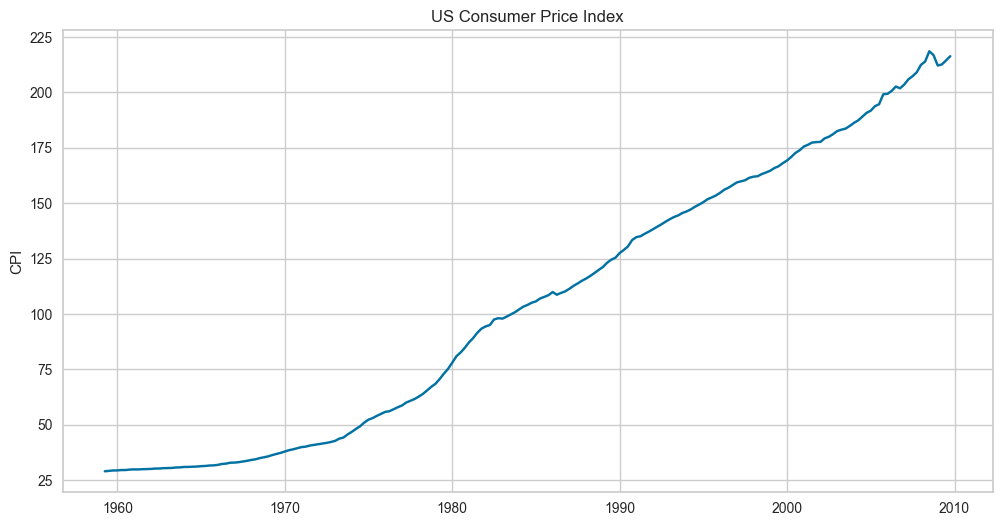

In [321]:
# plot the data
plt.figure(figsize=(12,6))
plt.plot(data)
plt.title('US Consumer Price Index')
plt.ylabel('CPI')
plt.show()

Because the data is not stationary (clear upward trend) the decision tree forecasts will be poor in the sense of not capturing the trend. It tends to overfit in the near future and ignore the overall direction. 

## 5. 

Prepare your dataset for supervised machine learning task by adding 3 lags to the data set (note: make sure to remove the NA observations after creating lag variables)

In [322]:
data = data.copy()

data['lag_1'] = data['cpi'].shift(1)
data['lag_2'] = data['cpi'].shift(2)
data['lag_3'] = data['cpi'].shift(3)

# creating lags adds NA values which we will drop
data = data.dropna()

data.head()

,cpi,lag_1,lag_2,lag_3
1959-12-31,29.37,29.35,29.15,28.98
1960-03-31,29.54,29.37,29.35,29.15
1960-06-30,29.55,29.54,29.37,29.35
1960-09-30,29.75,29.55,29.54,29.37
1960-12-31,29.84,29.75,29.55,29.54


## 6. 

Prepare the train and test set

### 1. 

Split the data into train and test. Keep the last 24 observations in the test set and the rest in the train set. Specify your features X and target variable y. What is the shape of your data_train and data_test set?

In [323]:
test_size = 24
train_size = len(data) - test_size

data_train = data.iloc[:train_size]
data_test = data.iloc[train_size:]

In [324]:
data_train.shape, data_test.shape

((176, 4), (24, 4))

In [325]:
X = data_train[['lag_1', 'lag_2', 'lag_3']]
y = data_train['cpi']

### 2. 

Why can't you use train_test_split() function from sklearn here? What's wrong with that approach?

We can't use that approach because it randomly selects the data to put into the train and test. 

## 7. 

Train a simple decision tree modle with max_depth=10 and report the MAPE in the train set. Does this mean that your model is complex enough? Can the model overfit the data?

In [326]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_absolute_percentage_error

In [327]:
dt_model = DecisionTreeRegressor(max_depth=10)
dt_model.fit(X, y)

data_train['DT_Predictions'] = dt_model.predict(X)

train_mape = mean_absolute_percentage_error(data_train['cpi'], data_train['DT_Predictions'])
print(f'Train MAPE: {train_mape}')

Train MAPE: 0.0


C:\Users\clata\AppData\Local\Temp\ipykernel_28464\466037453.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train['DT_Predictions'] = dt_model.predict(X)


The model is too complex because and it is not capturing the trend which is causing overfitting in the train data.

## 8. 

Make some forecasts in the test set (the last 24 observations, this is what pycaret calls hold out set)

### 1. 

Why can't we use something like y_test_pred = dt_model.predict(X_test). What is wrong with that approach?

We can't do that due to a lack of lag terms as we forecast out of sample. The default method of predict() is multi output so we can't iteratively update the lags as we move out of sample. 

### 2. 

The correct way is to create a forecast_future function (as we did in class) and make predictions into the future using the past predictions. Create that function and report the MAPE in the test set now.

In [328]:
# Define a function to forecast into the future

h = 24 # number of steps to forecast into the future 
def forecast_future(dt_model, data, steps=h):
    # Starting with the last known lag values
    last_lag1 = data['lag_1'].iloc[-1]
    last_lag2 = data['lag_2'].iloc[-1]
    last_lag3 = data['lag_3'].iloc[-1]
    
    # To store future predictions
    future_predictions = []
    
    for step in range(steps):
        # Format the input with the correct column names
        input_df = pd.DataFrame([[last_lag1, last_lag2, last_lag3]], columns=['lag_1', 'lag_2','lag_3'])
        
        # Predict the next value
        next_value_pred = dt_model.predict(input_df)[0]
        
        # Update lag values
        last_lag3 = last_lag2
        last_lag2 = last_lag1
        last_lag1 = next_value_pred
        
        future_predictions.append(next_value_pred)
    
    return future_predictions

In [329]:
# Forecast h months into the future
future_preds = forecast_future(dt_model, data_train, steps=h)

# Create a date range for the future predictions
last_date = data_train.index[-1]
future_dates = pd.date_range(start=last_date + pd.offsets.QuarterBegin(1), periods=h, freq='Q')

In [330]:
forecast_df = pd.DataFrame({'Date': future_dates, 'DT Predicitoins': future_preds})
forecast_df.set_index('Date', inplace=True)

In [331]:
test_actuals = data_test.loc[future_dates, 'cpi'].values

mape_test = mean_absolute_percentage_error(test_actuals, future_preds)

print(f"Mape on the test set: {mape_test}")

Mape on the test set: 0.08872469814856854


## 9.

The decision tree is performing poorly in the test set potentially due to the model complexity. It is capturing details and noise in the training data that is causing it to memorize patterns. It isn't learning just the underlying patterns but also the random fluctuations. Decision Trees by nature are prone to overfitting when the model is deep because it will split on any small difference. 

In [332]:
data_train.head()

,cpi,lag_1,lag_2,lag_3,DT_Predictions
1959-12-31,29.37,29.35,29.15,28.98,29.37
1960-03-31,29.54,29.37,29.35,29.15,29.54
1960-06-30,29.55,29.54,29.37,29.35,29.55
1960-09-30,29.75,29.55,29.54,29.37,29.75
1960-12-31,29.84,29.75,29.55,29.54,29.84


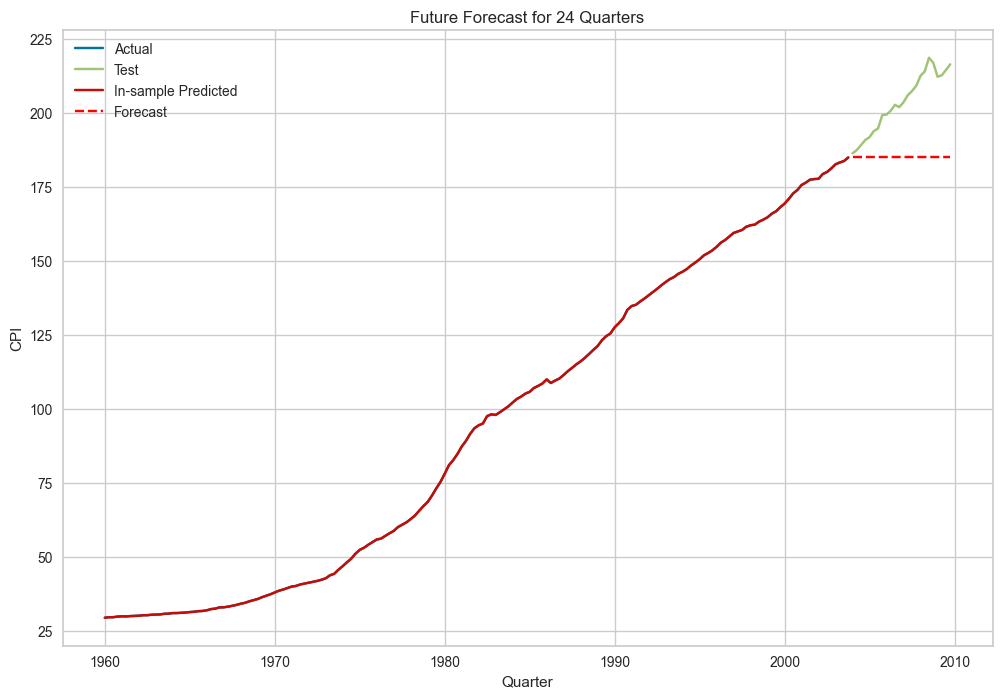

In [333]:
# Visualize the forecast along with the actual data and in-sample predictions
plt.figure(figsize=(12, 8))
plt.plot(data_train.index, data_train['cpi'], label='Actual')
plt.plot(data_test.index, data_test['cpi'], label='Test')
plt.plot(data_train.index, data_train['DT_Predictions'], label='In-sample Predicted')
plt.plot(forecast_df.index, forecast_df, label='Forecast', linestyle='--', color='red')
plt.title(f'Future Forecast for {h} Quarters')
plt.xlabel('Quarter')
plt.ylabel('CPI')
plt.legend()
plt.show()

## 10.

In [334]:
diff_data = pd.read_csv('https://raw.githubusercontent.com/PJalgotrader/Deep_forecasting-USU/refs/heads/main/data/US_macro_Quarterly.csv', index_col=0)

diff_data.index = diff_data.index = pd.to_datetime(diff_data.index)

diff_data = diff_data[['cpi']]

In [335]:
# difference the data
diff_data['diff_cpi'] = diff_data['cpi'].diff()

# create 3 lagged variables
diff_data['lag_1'] = diff_data['diff_cpi'].shift(1)
diff_data['lag_2'] = diff_data['diff_cpi'].shift(2)
diff_data['lag_3'] = diff_data['diff_cpi'].shift(3)

# drop NA values
diff_data.dropna(inplace=True)

diff_data = diff_data[['diff_cpi', 'lag_1', 'lag_2', 'lag_3', 'cpi']]

In [336]:
# splitting into train and test
train_size = len(diff_data) - test_size

diff_data_train = diff_data.iloc[:train_size]
diff_data_test = diff_data.iloc[train_size:]

In [337]:
# creating X and y
X = diff_data_train[['lag_1', 'lag_2', 'lag_3']]
y = diff_data_train['diff_cpi']

In [338]:
# train the mod on the new X and y
dt_model_diff = DecisionTreeRegressor(max_depth=10)
dt_model_diff.fit(X, y)

DecisionTreeRegressor(max_depth=10)

In [339]:
# Make predictions on the differenced train set
diff_data_train = diff_data_train.copy()
diff_data_train['DT_Predictions'] = dt_model_diff.predict(X)

# Get the last known original CPI value before differencing
last_known_cpi = diff_data_train['cpi'].iloc[0]

# Undifference the train set predictions
train_cpi_preds = [last_known_cpi]
for diff_pred in diff_data_train['DT_Predictions']:
    train_cpi_preds.append(train_cpi_preds[-1] + diff_pred)

# Assign undifferenced CPI predictions to the DataFrame
diff_data_train['CPI_Predictions'] = train_cpi_preds[1:]

In [340]:
last_known_cpi = diff_data_train['cpi'].iloc[-1]
future_diff_predictions = forecast_future(dt_model_diff, diff_data_train, steps=h)

# Create a date range for the future predictions
last_date = diff_data_train.index[-1]
future_dates = pd.date_range(start=last_date + pd.offsets.QuarterBegin(1), periods=h, freq='Q')

# Combine future dates with CPI level forecasts into a DataFrame
forecast_df = pd.DataFrame({'Date': future_dates, 'Forecasted_CPI': future_diff_predictions})
forecast_df.set_index('Date', inplace=True)

In [341]:
# Undifference the future CPI predictions
test_cpi_pred = [last_known_cpi]
for diff_pred in future_diff_predictions:
    test_cpi_pred.append(test_cpi_pred[-1] + diff_pred)

# Assign undifferenced CPI predictions to the DataFrame
forecast_df['Forecasted_CPI'] = test_cpi_pred[1:]

In [342]:
from sklearn.metrics import mean_absolute_percentage_error

# Extract the actual CPI values from the test set
actual_cpi_test = diff_data_test['cpi'].values

# Calculate MAPE on the test set
mape_test = mean_absolute_percentage_error(actual_cpi_test, forecast_df)
print(f"MAPE on the test set: {mape_test}")

MAPE on the test set: 0.02090830333379304


## 11. 

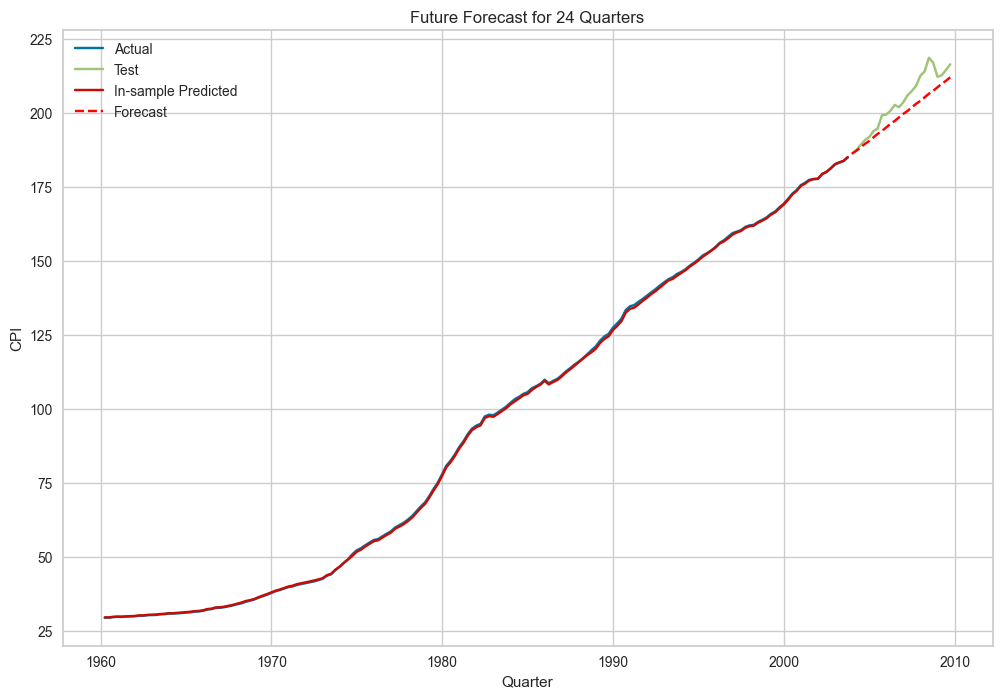

In [343]:
# Visualize the forecast along with the actual data and in-sample predictions
plt.figure(figsize=(12, 8))
plt.plot(diff_data_train.index, diff_data_train['cpi'], label='Actual')
plt.plot(diff_data_test.index, diff_data_test['cpi'], label='Test')
plt.plot(diff_data_train.index, diff_data_train['CPI_Predictions'], label='In-sample Predicted')
plt.plot(forecast_df.index, forecast_df, label='Forecast', linestyle='--', color='red')
plt.title(f'Future Forecast for {h} Quarters')
plt.xlabel('Quarter')
plt.ylabel('CPI')
plt.legend()
plt.show()

## 12.

In [344]:
from pycaret.time_series import *

In [345]:
exp = setup(data = data, target='cpi', fh=24, session_id=1000)

,Description,Value
0,session_id,1000
1,Target,cpi
2,Approach,Univariate
3,Exogenous Variables,Present
4,Original data shape,"(200, 4)"
5,Transformed data shape,"(200, 4)"
6,Transformed train set shape,"(176, 4)"
7,Transformed test set shape,"(24, 4)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


In [346]:
exp.compare_models(cross_validation=False)

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
auto_arima,Auto ARIMA,0.5400,0.6324,1.4462,2.0067,0.0070,0.0069,0.9593,4.5600
ridge_cds_dt,Ridge w/ Cond. Deseasonalize & Detrending,0.6743,0.7313,1.8060,2.3205,0.0087,0.0087,0.9456,0.0500
br_cds_dt,Bayesian Ridge w/ Cond. Deseasonalize & Detrending,0.6806,0.7370,1.8227,2.3384,0.0088,0.0088,0.9447,0.0400
huber_cds_dt,Huber w/ Cond. Deseasonalize & Detrending,0.6826,0.7416,1.8282,2.3532,0.0088,0.0088,0.9440,0.0500
arima,ARIMA,0.6944,0.7453,1.8598,2.3650,0.0090,0.0090,0.9435,0.1200
en_cds_dt,Elastic Net w/ Cond. Deseasonalize & Detrending,0.9678,1.1222,2.5920,3.5606,0.0124,0.0126,0.8719,0.0300
lasso_cds_dt,Lasso w/ Cond. Deseasonalize & Detrending,1.0895,1.2174,2.9179,3.8629,0.0140,0.0142,0.8492,0.0400
llar_cds_dt,Lasso Least Angular Regressor w/ Cond. Deseasonalize & Detrending,1.0895,1.2174,2.9179,3.8629,0.0140,0.0142,0.8492,0.0400
lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,1.4195,1.4724,3.8018,4.6718,0.0183,0.0185,0.7794,0.0400
omp_cds_dt,Orthogonal Matching Pursuit w/ Cond. Deseasonalize & Detrending,1.8292,1.8446,4.8991,5.8529,0.0235,0.0239,0.6538,0.0400


c:\Users\clata\OneDrive\Desktop\School\Fall 2024\Deep Forecasting\Module 5\.venv\Lib\site-packages\pycaret\internal\pycaret_experiment\supervised_experiment.py:713: UserWarning: Unsupported estimator `ensemble_forecaster` for method `compare_models()`, removing from model_library
  warnings.warn(


AutoARIMA(random_state=1000, sp=3, suppress_warnings=True)

It appears that econometrics models are winning this competition with ARIMA at the top

# Question 2

In [347]:
df = pd.read_csv("https://raw.githubusercontent.com/PJalgotrader/Deep_forecasting-USU/main/data/yfinance.csv", index_col=0, header=[0,1])
df.head()

Adj Close                                                 \
                 AAPL         GLD       MSFT         QQQ         SPY   
Date                                                                   
2018-01-02  40.722874  125.150002  80.229012  152.072800  243.072266   
2018-01-03  40.715786  124.820000  80.602394  153.550400  244.609711   
2018-01-04  40.904907  125.459999  81.311806  153.819046  245.640732   
2018-01-05  41.370617  125.330002  82.319908  155.363861  247.277679   
2018-01-08  41.216949  125.309998  82.403923  155.968399  247.729935   

                                      Close                         ...  \
                 TSLA        USO       AAPL         GLD       MSFT  ...   
Date                                                                ...   
2018-01-02  21.368668  96.559998  43.064999  125.150002  85.949997  ...   
2018-01-03  21.150000  98.720001  43.057499  124.820000  86.349998  ...   
2018-01-04  20.974667  98.959999  43.257500  125.459999  87.110001  ...   
2018-01-05  21.105333  98.480003  43.750000  125.330002  88.190002  ...   
2018-01-08  22.427334  99.040001  43.587502  125.309998  88.279999  ...   

                  Open                           Volume                      \
                   SPY       TSLA        USO       AAPL       GLD      MSFT   
Date                                                                          
2018-01-02  267.839996  20.799999  96.559998  102223600  11762500  22483800   
2018-01-03  268.959991  21.400000  97.360001  118071600   7904300  26061400   
2018-01-04  271.200012  20.858000  98.639999   89738400   7329700  21912000   
2018-01-05  272.510010  21.108000  98.239998   94640000   5739900  23407100   
2018-01-08  273.309998  21.066668  98.480003   82271200   3566700  22113000   

                                                    
                 QQQ       SPY       TSLA      USO  
Date                                                
2018-01-02  32573300  86655700   65283000  1497588  
2018-01-03  29383600  90070400   67822500  2156150  
2018-01-04  24776100  80636400  149194500  1480988  
2018-01-05  26992300  83524000   68868000  1609888  
2018-01-08  23159100  57319200  147891000  1229225  

[5 rows x 42 columns]

In [348]:
# setting frequency of the data
df.index.freq = "B"

# setting the index to datetime
df.index = pd.to_datetime(df.index)

# resampling the data to business days
df = df.resample('B').ffill()

In [349]:
df = df['Adj Close']['MSFT']

In [350]:
exp = setup(data = df, target='MSFT', fh=24, session_id=1000)

,Description,Value
0,session_id,1000
1,Target,MSFT
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(1564, 1)"
5,Transformed data shape,"(1564, 1)"
6,Transformed train set shape,"(1540, 1)"
7,Transformed test set shape,"(24, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


In [351]:
exp.compare_models(cross_validation=False)

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
omp_cds_dt,Orthogonal Matching Pursuit w/ Cond. Deseasonalize & Detrending,0.5139,0.4686,3.9223,4.8457,0.0106,0.0105,-0.9676,0.0300
llar_cds_dt,Lasso Least Angular Regressor w/ Cond. Deseasonalize & Detrending,0.5831,0.5038,4.4500,5.2098,0.0120,0.0119,-1.2744,0.0400
lasso_cds_dt,Lasso w/ Cond. Deseasonalize & Detrending,0.5832,0.5039,4.4511,5.2106,0.0120,0.0119,-1.2751,0.0400
lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,0.6047,0.5139,4.6151,5.3135,0.0124,0.0123,-1.3658,0.0400
ridge_cds_dt,Ridge w/ Cond. Deseasonalize & Detrending,0.6047,0.5139,4.6151,5.3135,0.0124,0.0123,-1.3658,0.0400
br_cds_dt,Bayesian Ridge w/ Cond. Deseasonalize & Detrending,0.6049,0.5140,4.6170,5.3155,0.0124,0.0123,-1.3676,0.0400
en_cds_dt,Elastic Net w/ Cond. Deseasonalize & Detrending,0.6099,0.5199,4.6546,5.3762,0.0125,0.0124,-1.4220,0.0400
snaive,Seasonal Naive Forecaster,0.6498,0.5612,4.9596,5.8033,0.0133,0.0133,-1.8221,0.0100
naive,Naive Forecaster,0.7059,0.5879,5.3875,6.0787,0.0145,0.0144,-2.0963,0.0200
theta,Theta Forecaster,0.8534,0.6924,6.5132,7.1601,0.0175,0.0173,-3.2960,0.0100


c:\Users\clata\OneDrive\Desktop\School\Fall 2024\Deep Forecasting\Module 5\.venv\Lib\site-packages\pycaret\internal\pycaret_experiment\supervised_experiment.py:713: UserWarning: Unsupported estimator `ensemble_forecaster` for method `compare_models()`, removing from model_library
  warnings.warn(
c:\Users\clata\OneDrive\Desktop\School\Fall 2024\Deep Forecasting\Module 5\.venv\Lib\site-packages\lightgbm\basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
c:\Users\clata\OneDrive\Desktop\School\Fall 2024\Deep Forecasting\Module 5\.venv\Lib\site-packages\lightgbm\basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
c:\Users\clata\OneDrive\Desktop\School\Fall 2024\Deep Forecasting\Module 5\.venv\Lib\site-packages\lightgbm\basic.py:722: UserWarning: Usage of np.ndarray subset (slice

BaseCdsDtForecaster(fe_target_rr=[WindowSummarizer(lag_feature={'lag': [9, 8, 7,
                                                                        6, 5, 4,
                                                                        3, 2,
                                                                        1]},
                                                   n_jobs=1)],
                    regressor=OrthogonalMatchingPursuit(), sp=9,
                    window_length=9)

The winning model for Microsoft is a machine learning model called

Orthogonal Matching Pursuit w/ Cond. Deseasonalize & Detrending